# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.46KFile/s]


Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

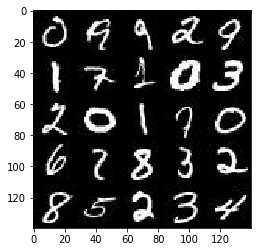

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

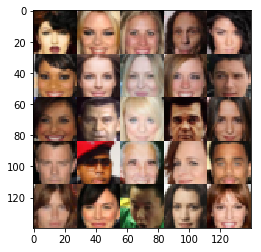

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28 * 28 * 3
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * layer1, layer1)
        # 14 * 14 * 64
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 128
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 * 4 * 256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [47]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        layer1 = tf.layers.dense(z, 2 * 2 * 512)
        layer1 = tf.reshape(layer1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(layer1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2 * 2 * 512
        
        layer2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(layer2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 * 7 * 256
        
        layer3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(layer3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14 * 14 * 128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28 * 28 * out_channel_dim
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [40]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, learning_rate_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate_ph: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}...".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
        
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.5129... Generator Loss: 8.8289...
Epoch 1/2... Discriminator Loss: 1.0660... Generator Loss: 0.7391...
Epoch 1/2... Discriminator Loss: 0.4041... Generator Loss: 3.6284...
Epoch 1/2... Discriminator Loss: 0.4084... Generator Loss: 4.1181...
Epoch 1/2... Discriminator Loss: 0.6472... Generator Loss: 1.7637...
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 5.6297...
Epoch 1/2... Discriminator Loss: 2.4558... Generator Loss: 4.9519...
Epoch 1/2... Discriminator Loss: 1.5147... Generator Loss: 0.4868...
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.3258...
Epoch 1/2... Discriminator Loss: 0.6566... Generator Loss: 1.7931...


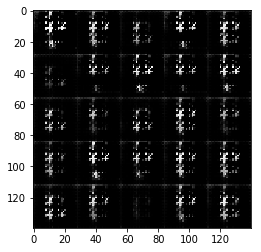

Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.8419...
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.5329...
Epoch 1/2... Discriminator Loss: 1.0462... Generator Loss: 3.4198...
Epoch 1/2... Discriminator Loss: 0.7544... Generator Loss: 2.5185...
Epoch 1/2... Discriminator Loss: 0.9675... Generator Loss: 1.8106...
Epoch 1/2... Discriminator Loss: 1.0014... Generator Loss: 1.3104...
Epoch 1/2... Discriminator Loss: 0.6414... Generator Loss: 2.4599...
Epoch 1/2... Discriminator Loss: 0.6854... Generator Loss: 1.7672...
Epoch 1/2... Discriminator Loss: 1.1056... Generator Loss: 1.3291...
Epoch 1/2... Discriminator Loss: 0.6608... Generator Loss: 1.9504...


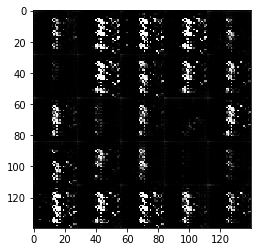

Epoch 1/2... Discriminator Loss: 2.0754... Generator Loss: 0.2412...
Epoch 1/2... Discriminator Loss: 1.2661... Generator Loss: 1.0411...
Epoch 1/2... Discriminator Loss: 0.6288... Generator Loss: 2.2221...
Epoch 1/2... Discriminator Loss: 0.5689... Generator Loss: 2.8980...
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.1271...
Epoch 1/2... Discriminator Loss: 0.8350... Generator Loss: 5.0407...
Epoch 1/2... Discriminator Loss: 0.9049... Generator Loss: 1.9793...
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 2.7387...
Epoch 1/2... Discriminator Loss: 0.7831... Generator Loss: 1.6411...
Epoch 1/2... Discriminator Loss: 0.7788... Generator Loss: 2.2379...


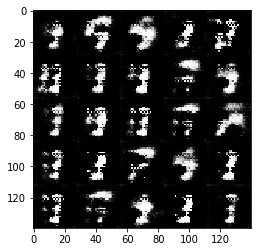

Epoch 1/2... Discriminator Loss: 1.0777... Generator Loss: 1.3880...
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 1.0981...
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 2.1682...
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 1.7783...
Epoch 1/2... Discriminator Loss: 0.9018... Generator Loss: 1.1239...
Epoch 1/2... Discriminator Loss: 0.9310... Generator Loss: 1.2616...
Epoch 1/2... Discriminator Loss: 1.2750... Generator Loss: 0.7097...
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.9019...
Epoch 1/2... Discriminator Loss: 1.2526... Generator Loss: 0.7331...
Epoch 1/2... Discriminator Loss: 1.0974... Generator Loss: 1.3523...


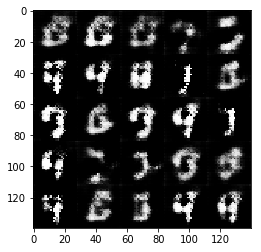

Epoch 1/2... Discriminator Loss: 1.3127... Generator Loss: 0.7364...
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.6408...
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 1.0190...
Epoch 1/2... Discriminator Loss: 1.1925... Generator Loss: 0.8845...
Epoch 1/2... Discriminator Loss: 1.1508... Generator Loss: 1.3211...
Epoch 1/2... Discriminator Loss: 0.9290... Generator Loss: 1.4124...
Epoch 1/2... Discriminator Loss: 1.0286... Generator Loss: 1.1175...
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.5907...
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.9781...
Epoch 1/2... Discriminator Loss: 0.8930... Generator Loss: 1.5330...


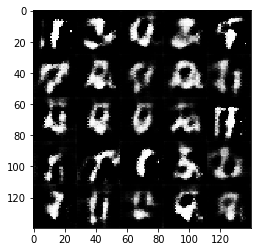

Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.6425...
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 1.0686...
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 1.9759...
Epoch 1/2... Discriminator Loss: 1.4575... Generator Loss: 0.5357...
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 1.7728...
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.9763...
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 1.1556...
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 1.6104...
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 1.6886...
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 1.8323...


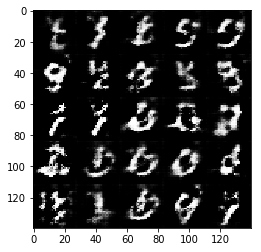

Epoch 1/2... Discriminator Loss: 1.2415... Generator Loss: 0.8722...
Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.2757...
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 1.4034...
Epoch 1/2... Discriminator Loss: 1.0469... Generator Loss: 1.4602...
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.8038...
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.9693...
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.8780...
Epoch 1/2... Discriminator Loss: 0.9727... Generator Loss: 1.4155...
Epoch 1/2... Discriminator Loss: 1.2114... Generator Loss: 0.9860...
Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 1.2059...


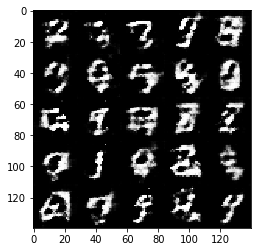

Epoch 1/2... Discriminator Loss: 0.9766... Generator Loss: 1.5185...
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.3930...
Epoch 1/2... Discriminator Loss: 1.3476... Generator Loss: 0.6564...
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.1071...
Epoch 1/2... Discriminator Loss: 0.8834... Generator Loss: 1.4253...
Epoch 1/2... Discriminator Loss: 0.9153... Generator Loss: 1.4494...
Epoch 1/2... Discriminator Loss: 1.2360... Generator Loss: 1.5666...
Epoch 1/2... Discriminator Loss: 1.4030... Generator Loss: 0.6286...
Epoch 1/2... Discriminator Loss: 1.1995... Generator Loss: 0.7422...
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.5295...


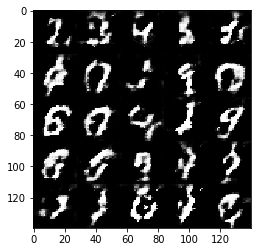

Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 1.8660...
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.8305...
Epoch 1/2... Discriminator Loss: 1.0735... Generator Loss: 1.0460...
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.4045...
Epoch 1/2... Discriminator Loss: 1.0191... Generator Loss: 1.1151...
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 1.2999...
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 1.0044...
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 1.0903...
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 1.0336...
Epoch 1/2... Discriminator Loss: 1.1697... Generator Loss: 1.0304...


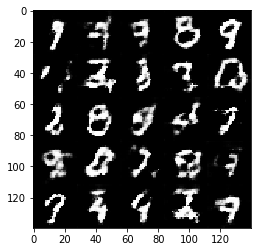

Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 1.1582...
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.3595...
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.9269...
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 1.2925...
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.1767...
Epoch 2/2... Discriminator Loss: 1.2343... Generator Loss: 1.4671...
Epoch 2/2... Discriminator Loss: 1.1912... Generator Loss: 1.0343...
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 1.5395...
Epoch 2/2... Discriminator Loss: 1.2317... Generator Loss: 0.9958...
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 1.9305...


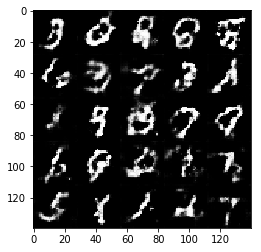

Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 1.2860...
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 1.0515...
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.9759...
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.8663...
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.7935...
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 1.1418...
Epoch 2/2... Discriminator Loss: 1.2712... Generator Loss: 0.7922...
Epoch 2/2... Discriminator Loss: 1.1974... Generator Loss: 1.3955...
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 1.2960...
Epoch 2/2... Discriminator Loss: 1.2092... Generator Loss: 1.0272...


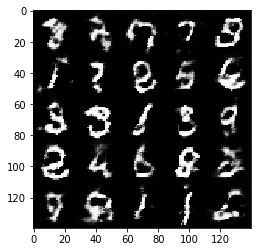

Epoch 2/2... Discriminator Loss: 1.1932... Generator Loss: 0.8775...
Epoch 2/2... Discriminator Loss: 1.4971... Generator Loss: 0.5279...
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 1.0772...
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.0046...
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.9726...
Epoch 2/2... Discriminator Loss: 1.2367... Generator Loss: 0.6786...
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.7806...
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.8339...
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 1.2081...
Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 1.0929...


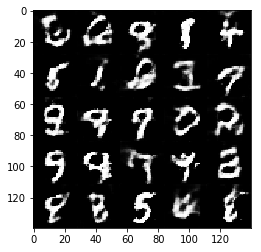

Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 1.8489...
Epoch 2/2... Discriminator Loss: 1.1546... Generator Loss: 1.1935...
Epoch 2/2... Discriminator Loss: 1.1065... Generator Loss: 1.0713...
Epoch 2/2... Discriminator Loss: 1.2173... Generator Loss: 0.8173...
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 1.2272...
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.8169...
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 1.0858...
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.7648...
Epoch 2/2... Discriminator Loss: 1.2492... Generator Loss: 1.0759...
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 0.7188...


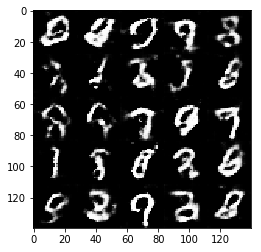

Epoch 2/2... Discriminator Loss: 1.3418... Generator Loss: 0.7672...
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 1.3036...
Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 1.0717...
Epoch 2/2... Discriminator Loss: 1.2406... Generator Loss: 0.8804...
Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 1.5459...
Epoch 2/2... Discriminator Loss: 1.3499... Generator Loss: 1.0791...
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 1.2353...
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 1.0530...
Epoch 2/2... Discriminator Loss: 1.2781... Generator Loss: 0.8745...
Epoch 2/2... Discriminator Loss: 1.2296... Generator Loss: 1.6269...


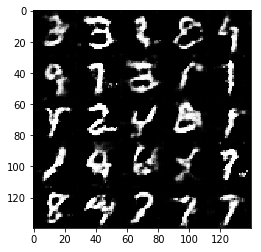

Epoch 2/2... Discriminator Loss: 1.3019... Generator Loss: 0.7814...
Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 0.8730...
Epoch 2/2... Discriminator Loss: 1.3657... Generator Loss: 0.7580...
Epoch 2/2... Discriminator Loss: 1.2216... Generator Loss: 0.8449...
Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 1.1480...
Epoch 2/2... Discriminator Loss: 1.1596... Generator Loss: 1.0364...
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 1.2460...
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 1.1140...
Epoch 2/2... Discriminator Loss: 1.3069... Generator Loss: 0.7150...
Epoch 2/2... Discriminator Loss: 1.2280... Generator Loss: 1.1287...


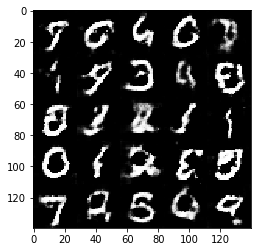

Epoch 2/2... Discriminator Loss: 1.3364... Generator Loss: 0.9964...
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.9070...
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.9320...
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 1.2661...
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 0.9876...
Epoch 2/2... Discriminator Loss: 1.2185... Generator Loss: 0.9968...
Epoch 2/2... Discriminator Loss: 1.3851... Generator Loss: 1.0881...
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 1.3277...
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.9128...
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 1.4869...


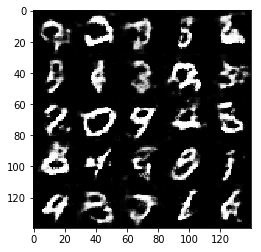

Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 1.2381...
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.9030...
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 1.0492...
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 1.1974...
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 1.0546...
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 0.8002...
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 1.1837...
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 1.1855...
Epoch 2/2... Discriminator Loss: 1.2407... Generator Loss: 0.8316...
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.9398...


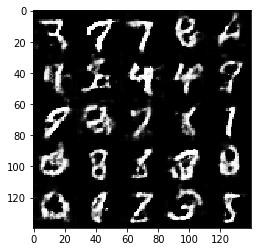

Epoch 2/2... Discriminator Loss: 1.2943... Generator Loss: 0.8315...
Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 1.1975...
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.9038...
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 1.0346...
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.8520...
Epoch 2/2... Discriminator Loss: 1.2826... Generator Loss: 0.7812...
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.9235...
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.7186...
Epoch 2/2... Discriminator Loss: 1.2177... Generator Loss: 0.8920...
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.8567...


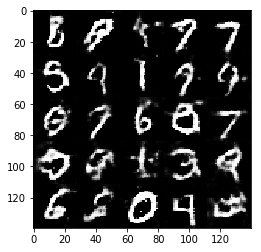

Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.7471...
Epoch 2/2... Discriminator Loss: 1.2638... Generator Loss: 0.8861...
Epoch 2/2... Discriminator Loss: 1.1953... Generator Loss: 1.1365...
Epoch 2/2... Discriminator Loss: 1.3194... Generator Loss: 0.7810...
Epoch 2/2... Discriminator Loss: 1.2631... Generator Loss: 0.9672...
Epoch 2/2... Discriminator Loss: 1.2963... Generator Loss: 1.3480...
Epoch 2/2... Discriminator Loss: 1.2036... Generator Loss: 1.0477...


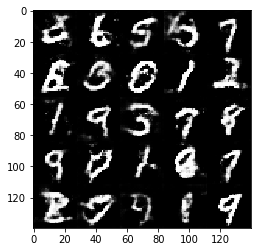

In [48]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.6499... Generator Loss: 4.6443...
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 4.8294...
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 3.4811...
Epoch 1/1... Discriminator Loss: 0.5612... Generator Loss: 2.6924...
Epoch 1/1... Discriminator Loss: 0.6155... Generator Loss: 2.5377...
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 1.0548...
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 5.3828...
Epoch 1/1... Discriminator Loss: 0.5763... Generator Loss: 2.4421...
Epoch 1/1... Discriminator Loss: 1.0480... Generator Loss: 1.0795...
Epoch 1/1... Discriminator Loss: 0.6300... Generator Loss: 2.9160...


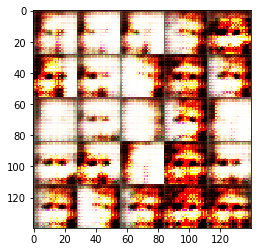

Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.8942...
Epoch 1/1... Discriminator Loss: 0.7040... Generator Loss: 2.1009...
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 1.7142...
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.4455...
Epoch 1/1... Discriminator Loss: 0.5385... Generator Loss: 2.5688...
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7943...
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 1.6892...
Epoch 1/1... Discriminator Loss: 3.4720... Generator Loss: 6.3745...
Epoch 1/1... Discriminator Loss: 0.7399... Generator Loss: 1.5741...
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.8776...


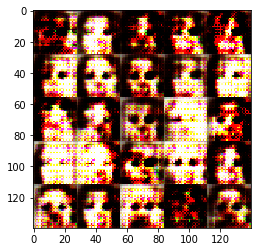

Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.7229...
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.9369...
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 1.8376...
Epoch 1/1... Discriminator Loss: 0.5838... Generator Loss: 1.9323...
Epoch 1/1... Discriminator Loss: 0.7309... Generator Loss: 1.6271...
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 2.2860...
Epoch 1/1... Discriminator Loss: 0.7998... Generator Loss: 1.3724...
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.4583...
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.6758...
Epoch 1/1... Discriminator Loss: 0.7720... Generator Loss: 1.7935...


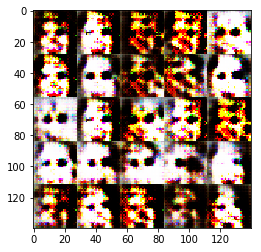

Epoch 1/1... Discriminator Loss: 1.2909... Generator Loss: 0.6183...
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.5757...
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.6839...
Epoch 1/1... Discriminator Loss: 0.6145... Generator Loss: 1.8980...
Epoch 1/1... Discriminator Loss: 0.6044... Generator Loss: 2.3030...
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 3.4000...
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 2.4732...
Epoch 1/1... Discriminator Loss: 0.7321... Generator Loss: 1.3704...
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 3.6715...
Epoch 1/1... Discriminator Loss: 0.8986... Generator Loss: 1.1329...


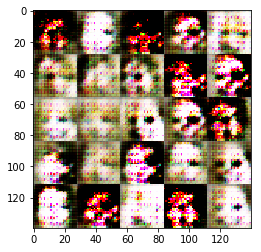

Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 1.7013...
Epoch 1/1... Discriminator Loss: 2.3462... Generator Loss: 7.2565...
Epoch 1/1... Discriminator Loss: 1.0561... Generator Loss: 1.6182...
Epoch 1/1... Discriminator Loss: 1.9887... Generator Loss: 3.6684...
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.8811...
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 2.6241...
Epoch 1/1... Discriminator Loss: 3.1919... Generator Loss: 3.1305...
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.7314...
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.8664...
Epoch 1/1... Discriminator Loss: 1.0108... Generator Loss: 0.9102...


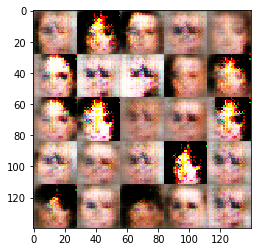

Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.1893...
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.1842...
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.6963...
Epoch 1/1... Discriminator Loss: 1.8503... Generator Loss: 3.1262...
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5304...
Epoch 1/1... Discriminator Loss: 2.0551... Generator Loss: 0.2635...
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6197...
Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.1349...
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8940...
Epoch 1/1... Discriminator Loss: 0.9883... Generator Loss: 1.1686...


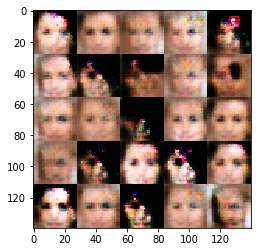

Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 2.6131...
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 2.1524...
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.6704...
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.0070...
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 1.2663...
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.3181...
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 0.8903...
Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.8822...
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.4131...
Epoch 1/1... Discriminator Loss: 1.9792... Generator Loss: 2.6804...


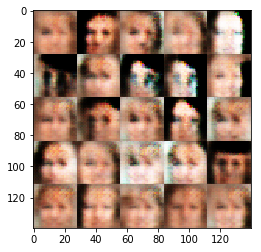

Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.5696...
Epoch 1/1... Discriminator Loss: 1.8041... Generator Loss: 0.3502...
Epoch 1/1... Discriminator Loss: 2.3041... Generator Loss: 3.9218...
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.8171...
Epoch 1/1... Discriminator Loss: 0.9569... Generator Loss: 1.3070...
Epoch 1/1... Discriminator Loss: 0.9904... Generator Loss: 1.6742...
Epoch 1/1... Discriminator Loss: 1.6756... Generator Loss: 3.6962...
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 1.5494...
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.7879...
Epoch 1/1... Discriminator Loss: 0.8056... Generator Loss: 1.5260...


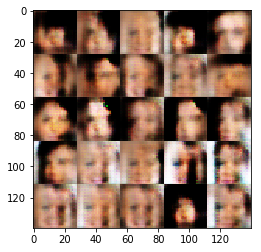

Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.6385...
Epoch 1/1... Discriminator Loss: 2.0044... Generator Loss: 2.8434...
Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 2.5349...
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 0.7863...
Epoch 1/1... Discriminator Loss: 0.7038... Generator Loss: 1.6139...
Epoch 1/1... Discriminator Loss: 0.4315... Generator Loss: 3.5241...
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.7831...
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 2.4724...
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.8140...
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 0.9345...


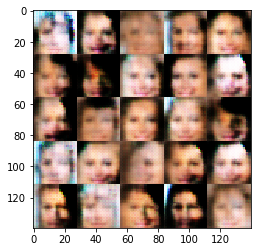

Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.4466...
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 2.8733...
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.4497...
Epoch 1/1... Discriminator Loss: 1.1785... Generator Loss: 1.7334...
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 1.6644...
Epoch 1/1... Discriminator Loss: 1.8946... Generator Loss: 0.2826...
Epoch 1/1... Discriminator Loss: 0.7426... Generator Loss: 1.5331...
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.3530...
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.6315...
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.3252...


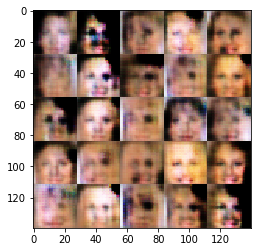

Epoch 1/1... Discriminator Loss: 0.7629... Generator Loss: 2.4468...
Epoch 1/1... Discriminator Loss: 0.6407... Generator Loss: 2.1533...
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 2.7608...
Epoch 1/1... Discriminator Loss: 0.8166... Generator Loss: 1.8003...
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 2.1622...
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.9014...
Epoch 1/1... Discriminator Loss: 0.7432... Generator Loss: 1.3622...
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.7349...
Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 2.4668...
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 3.5668...


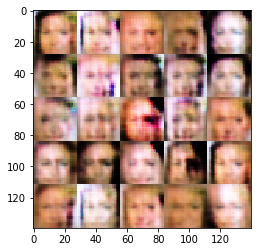

Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.8228...
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 3.0661...
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.8659...
Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0457...
Epoch 1/1... Discriminator Loss: 0.6078... Generator Loss: 2.7241...
Epoch 1/1... Discriminator Loss: 1.7311... Generator Loss: 3.5089...
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.6581...
Epoch 1/1... Discriminator Loss: 0.8827... Generator Loss: 1.0525...
Epoch 1/1... Discriminator Loss: 1.9323... Generator Loss: 0.2938...
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.8223...


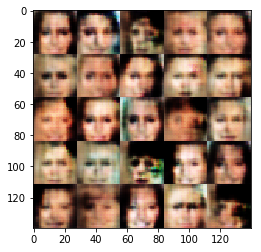

Epoch 1/1... Discriminator Loss: 0.9701... Generator Loss: 1.4569...
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 2.4821...
Epoch 1/1... Discriminator Loss: 1.0077... Generator Loss: 0.8856...
Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 1.7033...
Epoch 1/1... Discriminator Loss: 0.8980... Generator Loss: 2.1036...
Epoch 1/1... Discriminator Loss: 1.4118... Generator Loss: 0.5959...
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.4303...
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.4896...
Epoch 1/1... Discriminator Loss: 0.8662... Generator Loss: 1.4290...
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.8454...


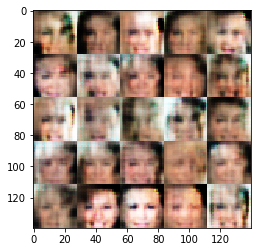

Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 2.1088...
Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.4421...
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 2.5798...
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 2.0988...
Epoch 1/1... Discriminator Loss: 1.2374... Generator Loss: 0.7419...
Epoch 1/1... Discriminator Loss: 0.9693... Generator Loss: 2.1121...
Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 3.5367...
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.0061...
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.8631...
Epoch 1/1... Discriminator Loss: 0.9019... Generator Loss: 1.0211...


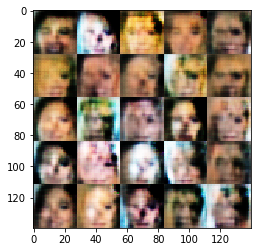

Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 1.3078...
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.0381...
Epoch 1/1... Discriminator Loss: 0.8621... Generator Loss: 1.2320...
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.5946...
Epoch 1/1... Discriminator Loss: 0.7338... Generator Loss: 1.6510...
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 0.9148...
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 2.0619...
Epoch 1/1... Discriminator Loss: 1.7759... Generator Loss: 3.1338...
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6923...
Epoch 1/1... Discriminator Loss: 0.6030... Generator Loss: 2.3663...


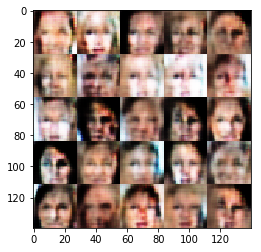

Epoch 1/1... Discriminator Loss: 0.8446... Generator Loss: 1.4293...
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.5992...
Epoch 1/1... Discriminator Loss: 0.9492... Generator Loss: 1.9162...
Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.7751...
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.4971...
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.7522...
Epoch 1/1... Discriminator Loss: 0.9172... Generator Loss: 1.9823...
Epoch 1/1... Discriminator Loss: 0.7604... Generator Loss: 1.9124...
Epoch 1/1... Discriminator Loss: 0.7245... Generator Loss: 1.9537...
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 3.4204...


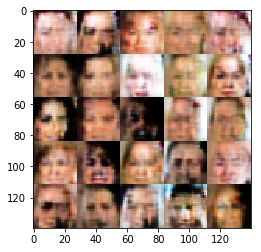

Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 2.6018...
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.1741...
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.7587...
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.9427...
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.2239...
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 2.1560...
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.9889...
Epoch 1/1... Discriminator Loss: 0.7421... Generator Loss: 2.1915...
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 2.1472...
Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 2.0097...


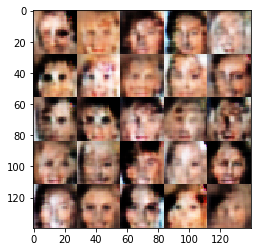

Epoch 1/1... Discriminator Loss: 0.6201... Generator Loss: 2.0039...
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.4586...
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.6760...
Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.1551...
Epoch 1/1... Discriminator Loss: 1.0794... Generator Loss: 0.9974...
Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 1.0762...
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.9936...
Epoch 1/1... Discriminator Loss: 1.1043... Generator Loss: 0.9645...
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 2.3455...
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 1.0300...


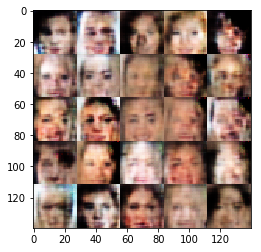

Epoch 1/1... Discriminator Loss: 0.7903... Generator Loss: 2.5302...
Epoch 1/1... Discriminator Loss: 1.2537... Generator Loss: 1.5640...
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 0.7889...
Epoch 1/1... Discriminator Loss: 1.4866... Generator Loss: 0.5377...
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 0.8308...
Epoch 1/1... Discriminator Loss: 1.1639... Generator Loss: 1.2103...
Epoch 1/1... Discriminator Loss: 0.9340... Generator Loss: 2.6257...
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.1225...
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 1.6745...
Epoch 1/1... Discriminator Loss: 0.6003... Generator Loss: 2.1221...


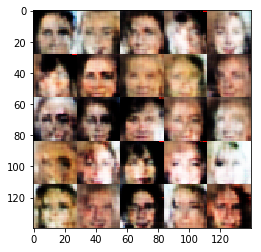

Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 2.1106...
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.1871...
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 0.8765...
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.8442...
Epoch 1/1... Discriminator Loss: 0.9914... Generator Loss: 1.3091...
Epoch 1/1... Discriminator Loss: 0.9740... Generator Loss: 0.9500...
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 2.1279...
Epoch 1/1... Discriminator Loss: 0.8277... Generator Loss: 1.6194...
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.8440...
Epoch 1/1... Discriminator Loss: 1.0579... Generator Loss: 0.8741...


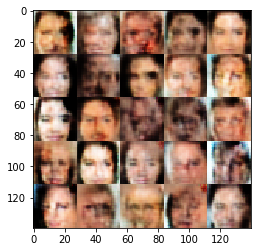

Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.9689...
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7109...
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.6216...
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.6017...
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 1.0629...
Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.1231...
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.4140...
Epoch 1/1... Discriminator Loss: 1.1105... Generator Loss: 0.8252...
Epoch 1/1... Discriminator Loss: 1.3400... Generator Loss: 2.2337...
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.3009...


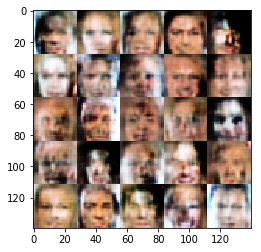

Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.4163...
Epoch 1/1... Discriminator Loss: 1.1222... Generator Loss: 0.8399...
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.9301...
Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9386...
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.1637...
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 2.3177...
Epoch 1/1... Discriminator Loss: 0.9762... Generator Loss: 2.1587...
Epoch 1/1... Discriminator Loss: 0.7880... Generator Loss: 1.4999...
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.8844...
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 0.8787...


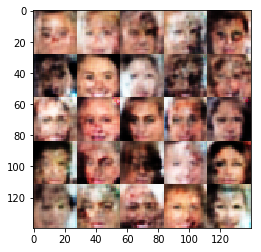

Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.8001...
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.7799...
Epoch 1/1... Discriminator Loss: 0.7375... Generator Loss: 1.7531...
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.2753...
Epoch 1/1... Discriminator Loss: 0.8950... Generator Loss: 1.5357...
Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.9865...
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 1.1538...
Epoch 1/1... Discriminator Loss: 0.7463... Generator Loss: 1.8839...
Epoch 1/1... Discriminator Loss: 1.1384... Generator Loss: 1.0341...
Epoch 1/1... Discriminator Loss: 0.7279... Generator Loss: 2.1335...


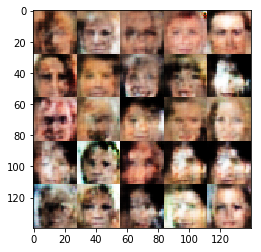

Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 2.1547...
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 1.2240...
Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.6851...
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 2.4869...
Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.2231...
Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 3.2627...
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8920...
Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.9352...
Epoch 1/1... Discriminator Loss: 0.9070... Generator Loss: 2.7173...
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 2.7692...


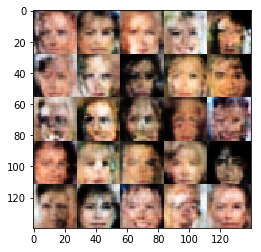

Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 0.8479...
Epoch 1/1... Discriminator Loss: 0.7138... Generator Loss: 2.2410...
Epoch 1/1... Discriminator Loss: 0.6363... Generator Loss: 2.1569...
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.9704...
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.2896...
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.3377...
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.6665...
Epoch 1/1... Discriminator Loss: 0.7306... Generator Loss: 2.2976...
Epoch 1/1... Discriminator Loss: 0.5409... Generator Loss: 2.4455...
Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9833...


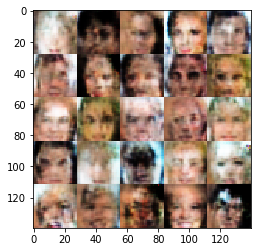

Epoch 1/1... Discriminator Loss: 0.8377... Generator Loss: 1.2187...
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 2.0181...
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 2.6507...
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 3.1806...
Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 2.6197...
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.1278...
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.9141...
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.9574...
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 2.7287...
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 0.8763...


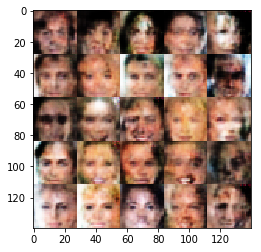

Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.3314...
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.5920...
Epoch 1/1... Discriminator Loss: 0.7547... Generator Loss: 1.3878...
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.6418...
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6622...
Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 2.2864...
Epoch 1/1... Discriminator Loss: 0.6068... Generator Loss: 2.1465...
Epoch 1/1... Discriminator Loss: 0.9786... Generator Loss: 1.0993...
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 0.8701...
Epoch 1/1... Discriminator Loss: 0.9018... Generator Loss: 2.4017...


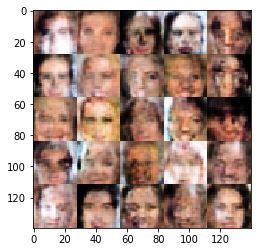

Epoch 1/1... Discriminator Loss: 0.7960... Generator Loss: 1.2909...
Epoch 1/1... Discriminator Loss: 0.6129... Generator Loss: 1.7633...
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 2.2845...
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.0024...
Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.4965...
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.8367...
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.7662...
Epoch 1/1... Discriminator Loss: 0.9703... Generator Loss: 1.0672...
Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 1.1241...
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.0352...


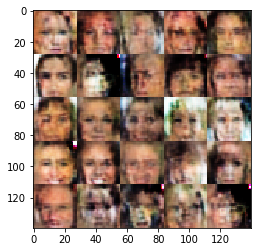

Epoch 1/1... Discriminator Loss: 0.5805... Generator Loss: 1.9244...
Epoch 1/1... Discriminator Loss: 1.7483... Generator Loss: 0.4548...
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.8845...
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 1.9528...
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.5545...
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 2.1987...
Epoch 1/1... Discriminator Loss: 1.7530... Generator Loss: 3.0426...
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 2.3327...
Epoch 1/1... Discriminator Loss: 1.2272... Generator Loss: 1.6632...
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 2.4277...


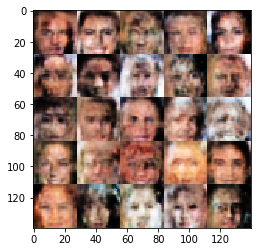

Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 1.1914...
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.2703...
Epoch 1/1... Discriminator Loss: 1.0005... Generator Loss: 1.7381...
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 2.3804...
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.7116...
Epoch 1/1... Discriminator Loss: 0.5459... Generator Loss: 2.3811...
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.8182...
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 2.0190...
Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.8053...
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 3.4426...


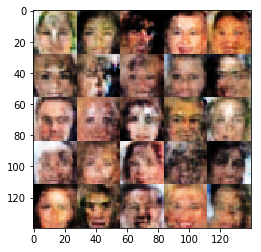

Epoch 1/1... Discriminator Loss: 1.5429... Generator Loss: 0.4805...
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.8240...
Epoch 1/1... Discriminator Loss: 0.7111... Generator Loss: 2.5337...
Epoch 1/1... Discriminator Loss: 0.8493... Generator Loss: 2.0537...
Epoch 1/1... Discriminator Loss: 1.0741... Generator Loss: 0.9111...
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 1.6853...
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.2608...
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.7545...
Epoch 1/1... Discriminator Loss: 0.5322... Generator Loss: 2.3269...
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.4090...


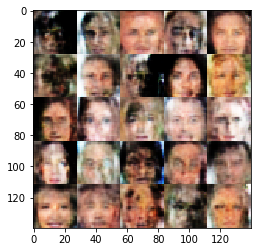

Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.4464...
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.5757...
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6778...
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8484...
Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 2.1876...
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.5149...


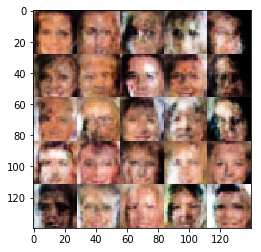

In [49]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。